# Make Figure 9 in submitted tadpole paper
## A. Ordog, Dec. 2023

In [1]:
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.coordinates import ICRS, Galactic, FK4, FK5
import numpy as np
import matplotlib.pyplot as plt
from astropy.wcs import WCS
from reproject import reproject_to_healpix, reproject_from_healpix
import json
from RMtools_1D.do_RMsynth_1D import run_rmsynth
from RMtools_1D.do_RMclean_1D import run_rmclean

## Set save_plots to True to save figures (will overwrite old ones)

In [2]:
save_plot = False

## Read in CHIME data files

In [3]:
hduQ   = fits.open('/srv/data/chime/tadpole_cutout/IQU_400_729/Q_400_729_Oct2023_tadpole_gal.fits')
hduU   = fits.open('/srv/data/chime/tadpole_cutout/IQU_400_729/U_400_729_Oct2023_tadpole_gal.fits')

hdupeak = fits.open('/srv/data/chime/tadpole_cutout/RMsynth_400_729/QU/FDF_peakRM.fits')
hduCLEAN = fits.open('/srv/data/chime/tadpole_cutout/RMsynth_400_729/QU/clean_200mJy/FDF_clean_tot.fits')
hduFWHM = fits.open('/srv/data/chime/tadpole_cutout/RMsynth_400_729/QU/RMSF_FWHM.fits')
hdupeakfit = fits.open('/srv/data/chime/tadpole_cutout/RMsynth_400_729/QU/dirty_phiPeakPIfit_rm2.fits')

Q = hduQ[0].data
U = hduU[0].data

hdrPA   = hduQ[0].header
hdr2D   = hdupeak[0].header
hdrFDF  = hduCLEAN[0].header
hdr2D   = hdupeakfit[0].header
#hdrRMSF = hduRMSF[0].header

peak     = hdupeak[0].data[0]
FDFclean = hduCLEAN[0].data
FWHM     = hduFWHM[0].data[0]
#RMSF     = hduRMSF[0].data

hdr2D['WCSAXES'] = 2
print(repr(hdr2D))

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  250                                                  
NAXIS2  =                  250                                                  
WCSAXES =                    2 / Number of coordinate axes                      
CRPIX1  =               1200.5 / Pixel coordinate of reference point            
CRPIX2  =                 80.5 / Pixel coordinate of reference point            
CDELT1  =               -0.125 / [deg] Coordinate increment at reference point  
CDELT2  =                0.125 / [deg] Coordinate increment at reference point  
CUNIT1  = 'deg'                / Units of coordinate increment and value        
CUNIT2  = 'deg'                / Units of coordinate increment and value        
CTYPE1  = 'GLON-CAR'        

In [4]:
freq = WCS(hdrPA).all_pix2world(0,0,range(Q.shape[0]),0)[2]
print(freq[0],freq[-1])

FD = WCS(hdrFDF).all_pix2world(0,0,range(FDFclean.shape[0]),0)[2]
print(FD[0],FD[-1])

729687500.0 400390625.0
-200.0 200.0


## Find second peaks in Faraday depth spectra

In [5]:
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

FDFclean_second = FDFclean.copy()

for i in range(0,FDFclean.shape[1]):
    #print(i)
    for j in range(0,FDFclean.shape[2]):
        w_peak = np.where(FD == peak[i,j])[0][0]
        RMSF_sub = gaussian(FD,peak[i,j],FWHM[i,j]/2.355)*FDFclean[w_peak,i,j]
        FDFclean_second[:,i,j] = FDFclean[:,i,j] - RMSF_sub

In [6]:
peak2 = np.empty_like(peak)
PIpeak2 = np.empty_like(peak)
for i in range(0,peak.shape[0]):
    #print(i)
    for j in range(0,peak.shape[1]):
        w = np.where(FDFclean_second[:,i,j] == np.nanmax(FDFclean_second[:,i,j]))[0][0]
        peak2[i,j] = FD[w]
        PIpeak2[i,j] = FDFclean_second[w,i,j]


## Mask for low polarized intensity in second peak map:

In [7]:
wbad1 = np.where(PIpeak2<0.2)
wbad2 = np.where(abs(peak2)>30)

peak2_good = peak2.copy()
peak2_good[wbad1] = np.nan
peak2_good[wbad2] = np.nan

## Read in QU fitting results:

In [8]:
directory = '/srv/data/chime/tadpole_cutout/QU_fitting_results/'

coords = np.genfromtxt(directory+'tadpole_points_all.dat', delimiter=' ')
#coords = np.genfromtxt(directory+'tadpole_paper_points.dat', delimiter=' ')
lon = coords[:,0]
lat = coords[:,1]
cat = coords[:,2]

filename = []
for i in range(0,len(lon)):
    filename.append('lon'+"{:.1f}".format(lon[i])+'_lat'+"{:.1f}".format(lat[i]))
    
idxh = np.where(cat==1)
idxt = np.where(cat==2)
idxo = np.where(cat==3)

In [9]:
def make_dictionaries():

    models = ['m1','m11','m2','m4']

    stats  = {}
    params = {}

    for model in models:

        # set up dictionary for statistics:
        stats[model] =  {}
        stats[model]['chiSq'] = []
        stats[model]['chiSqRed'] = []
        stats[model]['BIC'] = []

        # set up dictionary for parameters:
        params[model] = {}
        with open(directory+filename[0]+'_'+model+'_pymultinest.json', 'r') as json_file:
            qu_result = json.load(json_file)
            for parName in qu_result["parNames"]:
                params[model][parName] = []

        for file in filename:
            with open(directory+file+'_'+model+'_pymultinest.json', 'r') as json_file:         
                qu_result = json.load(json_file)

                # Get data for stats:
                stats[model]['chiSq'].append(qu_result["chiSq"])
                stats[model]['chiSqRed'].append(qu_result["chiSqRed"])
                stats[model]['BIC'].append(qu_result["BIC"])

                # Get data for parameters:
                for parName in qu_result["parNames"]:
                    params[model][parName].append(qu_result["values"][qu_result["parNames"].index(parName)])

        # Make everything into numpy arrays
        stats[model]['chiSq'] = np.array(stats[model]['chiSq'])
        stats[model]['chiSqRed'] = np.array(stats[model]['chiSqRed'])
        stats[model]['BIC'] = np.array(stats[model]['BIC']) 
        with open(directory+filename[0]+'_'+model+'_pymultinest.json', 'r') as json_file:
            qu_result = json.load(json_file)
            for parName in qu_result["parNames"]:
                params[model][parName] = np.array(params[model][parName])
                
    return params, stats

In [10]:
def sort_by_pol():
    
    print('Sorting by pol fraction...')
    print('')

    for model in ['m11','m4']:

        RM1_old = params[model]['RM1_radm2']; RM1_new = RM1_old.copy()
        RM2_old = params[model]['RM2_radm2']; RM2_new = RM2_old.copy()

        pol1_old = params[model]['fracPol1']; pol1_new = pol1_old.copy()
        pol2_old = params[model]['fracPol2']; pol2_new = pol2_old.copy()

        psi01_old = params[model]['psi01_deg']; psi01_new = psi01_old.copy()
        psi02_old = params[model]['psi02_deg']; psi02_new = psi02_old.copy()

        if model == 'm4':
            sigma1_old = params[model]['sigmaRM1_radm2']; sigma1_new = sigma1_old.copy()
            sigma2_old = params[model]['sigmaRM2_radm2']; sigma2_new = sigma2_old.copy()

        for i in range(0,len(lon)):
            if pol1_old[i] < pol2_old[i]:
                RM1_new[i] = RM2_old[i]
                RM2_new[i] = RM1_old[i]
                pol1_new[i] = pol2_old[i]
                pol2_new[i] = pol1_old[i]
                psi01_new[i] = psi02_old[i]
                psi02_new[i] = psi01_old[i]
                if model == 'm4':
                    sigma1_new[i] = sigma2_old[i]
                    sigma2_new[i] = sigma1_old[i]

        params[model]['RM1_radm2'] = RM1_new
        params[model]['RM2_radm2'] = RM2_new
        params[model]['fracPol1'] = pol1_new
        params[model]['fracPol2'] = pol2_new
        params[model]['psi01_deg'] = psi01_new
        params[model]['psi02_deg'] = psi02_new
        if model == 'm4':
            params[model]['sigmaRM1_radm2'] = sigma1_new
            params[model]['sigmaRM2_radm2'] = sigma2_new

    return params, stats

In [11]:
sort_pol = True
params, stats = make_dictionaries()
if sort_pol:
    params, stats = sort_by_pol()
    
print(params.keys())
print(params['m1'].keys())
print(params['m11'].keys())
print(params['m2'].keys())
print(params['m4'].keys())
print('')
print(stats.keys())
print(stats['m1'].keys())
print(stats['m11'].keys())
print(stats['m2'].keys())
print(stats['m4'].keys())

Sorting by pol fraction...

dict_keys(['m1', 'm11', 'm2', 'm4'])
dict_keys(['fracPol', 'psi0_deg', 'RM_radm2'])
dict_keys(['fracPol1', 'fracPol2', 'psi01_deg', 'psi02_deg', 'RM1_radm2', 'RM2_radm2'])
dict_keys(['fracPol', 'psi0_deg', 'RM_radm2', 'sigmaRM_radm2'])
dict_keys(['fracPol1', 'fracPol2', 'psi01_deg', 'psi02_deg', 'RM1_radm2', 'RM2_radm2', 'sigmaRM1_radm2', 'sigmaRM2_radm2'])

dict_keys(['m1', 'm11', 'm2', 'm4'])
dict_keys(['chiSq', 'chiSqRed', 'BIC'])
dict_keys(['chiSq', 'chiSqRed', 'BIC'])
dict_keys(['chiSq', 'chiSqRed', 'BIC'])
dict_keys(['chiSq', 'chiSqRed', 'BIC'])


## Keep only high fractional pol points for 2FD+DP model secondary peaks:

In [12]:
QU_good = np.where(params['m4']['fracPol2']>0.1)
print(QU_good)

(array([ 4, 11, 14, 17, 18, 19, 20, 21, 24, 25, 26, 27, 36, 39, 41, 42, 43,
       45, 46, 48, 49, 50]),)


## Make the plot:

296 614062500.0


<ipython-input-13-ae5f1e87ada8>:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("RdBu_r").copy()


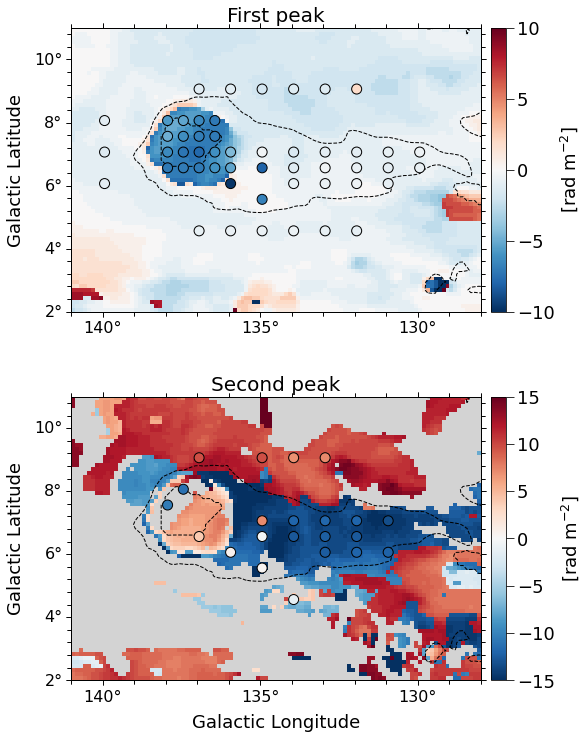

In [13]:
###############
freq_plot = 614e6
model = 'm4'
lrange = [141,128]
brange = [2,11]
fs = 16
###############

idx = WCS(hdrPA).wcs_world2pix(0,0,freq_plot,0)[2]
idx = int(np.round(idx,0))
print(idx, freq[idx])

crange = SkyCoord(lrange, brange, frame=Galactic, unit="deg")

fig = plt.figure(figsize=(9.5,12))
ax1 = fig.add_subplot(211, projection=WCS(hdr2D).celestial)
ax2 = fig.add_subplot(212, projection=WCS(hdr2D).celestial)

ims = []
c = SkyCoord(lon, lat, frame=Galactic, unit="deg")
pixels = WCS(hdr2D).world_to_pixel(c)
i = np.round(pixels[0],0).astype(int)
j = np.round(pixels[1],0).astype(int)
    
ims.append(ax1.scatter(i,j,s=100,c=params[model]['RM1_radm2'],cmap='RdBu_r',vmin=-10,vmax=10,
           zorder=100,edgecolor='k'))
ax1.imshow(peak,origin='lower',vmin=-10,vmax=10,cmap='RdBu_r')

cmap = plt.cm.get_cmap("RdBu_r").copy()
cmap.set_bad('lightgray')
ims.append(ax2.scatter(i[QU_good],j[QU_good],s=100,c=params[model]['RM2_radm2'][QU_good],
                       cmap=cmap,vmin=-15,vmax=15,zorder=100,edgecolor='k'))
ax2.imshow(peak2_good,origin='lower',vmin=-15,vmax=15,cmap=cmap)

cbars = []
i=0
for ax in [ax1,ax2]:
    

    ax.contour(0.5*np.arctan2(U[idx],Q[idx]), levels=[-np.pi/8], colors='black')
    ax.set_ylabel('Galactic Latitude',fontsize=fs+2)

    ax.set_xlim(WCS(hdr2D).world_to_pixel(crange)[0])
    ax.set_ylim(WCS(hdr2D).world_to_pixel(crange)[1])
    
    cbars.append(fig.colorbar(ims[i],ax=ax,orientation='vertical',fraction=0.035,pad=0.02,aspect=20))
    cbars[i].ax.tick_params(axis='y', which='both',labelsize=fs+2)
    cbars[i].set_label('[rad m$^{-2}$]', fontsize=fs+2)
    i=i+1
    
    ax.tick_params(axis='both', which='major', labelsize=fs, zorder=30, length=5)
    ax.coords[0].display_minor_ticks(True)
    ax.coords[1].display_minor_ticks(True)
    ax.coords.frame.set_linewidth(1)

ax2.set_xlabel('Galactic Longitude',fontsize=fs+2)
ax1.set_title('First peak',fontsize=fs+4)
ax2.set_title('Second peak',fontsize=fs+4)
ax1.set_xlabel(' ',fontsize=fs)

cbars[0].set_ticks([-10,-5,0,5,10])
cbars[1].set_ticks([-15,-10,-5,0,5,10,15])

plt.subplots_adjust(hspace=0.3)

if save_plot:
    #plt.tight_layout()
    plt.savefig('/srv/data/chime/tadpole_cutout/QU_fitting_plots_Nov14/RMsynth_QU_dots.png')